# Calculating Sheet Resistances (Current Source)

Here we compare various parameters against sheet resistance with current sources.

See here: [http://hdl.handle.net/2262/85922](http://hdl.handle.net/2262/85922)
for more information on the graphs as these were meant to replicate those ones.

An additional package `joblib` is used in this notebook for quick parallelization. This is extra and not required for the `randomnwn` package.

Furthermore, `monitor.py` should be present with this notebook for runtime measurements.

These graphs should be the same as the voltage sources.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

from scipy.stats import linregress
from scipy.special import erf

from randomnwn import *
from monitor import *

%load_ext line_profiler

units = get_units()

## Test Network Creation

Creation: 0.8897976000000014


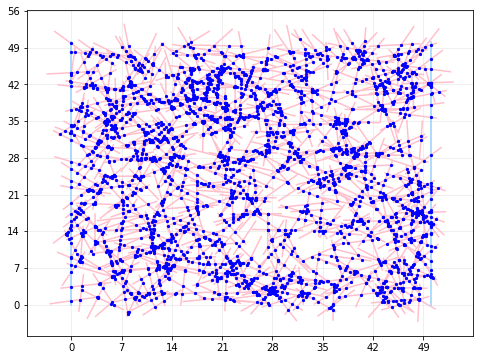

Plotting: 0.8466959000000003


In [2]:
length = 50.0 / units["l0"]
width = 50.0 / units["l0"]

with Runtime("Creation"):
    NWN = create_NWN(size=(length, width))
    add_electrodes(NWN, "left", "right")

with Runtime("Plotting"):
    plot_NWN(NWN, scaled=True)

In [3]:
NWN.graph["wire_num"]

752

In [4]:
with Runtime():
    current = solve_network(NWN, (750,), (751,), 30)[-1]
    print(current, "i0")

95.4485915124302 i0
Time elapsed: 0.06792000000000087


In [6]:
def sheet_resistance(NWN, left_node, right_node, voltage):
    current = solve_network(NWN, left_node, right_node, voltage)[-1]
    R_s = voltage / current
    return R_s

In [7]:
sheet_resistance(NWN, (750,), (751,), 30), "Ron"

(0.31430531896422087, 'Ron')

## R_s versus R_j Single Network

In [8]:
def resist_func(density, current, R_j, NWN_type="JDA"):
    density *= units["l0"]**2
    current /= units["i0"]
    R_j /= units["Ron"]
    size = 20.0 / units["l0"]

    # Create NWN
    NWN = create_NWN(size=size, conductance=1/R_j, density=density, seed=123)
    left, right = add_electrodes(NWN, "left", "right")
    if NWN_type == "MNR":
        convert_NWN_to_MNR(NWN)

    # Solve network voltages to get sheet resistance
    voltage_list = solve_network(NWN, left, right, current, type="current")
    voltage = voltage_list[-2] - voltage_list[-1]
    return (voltage / current) * units["Ron"]

In [9]:
junction_array = np.linspace(0.001, 100, 400)
with Parallel(n_jobs=-1, verbose=9) as parallel:
    Rs_list_JDA = parallel([delayed(resist_func)(0.4, 0.1, R_j, "JDA") for R_j in junction_array])
    Rs_list_MNR = parallel([delayed(resist_func)(0.4, 0.1, R_j, "MNR") for R_j in junction_array])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  26

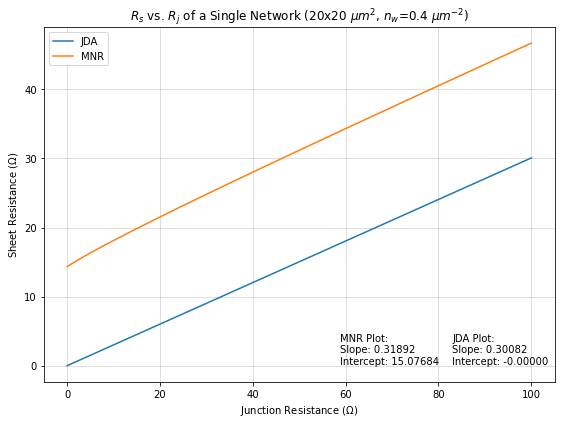

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(junction_array, Rs_list_JDA, label="JDA")
ax.plot(junction_array, Rs_list_MNR, label="MNR")
ax.set_xlabel(r"Junction Resistance ($\Omega$)")
ax.set_ylabel(r"Sheet Resistance ($\Omega$)")
ax.set_title(r"$R_s$ vs. $R_j$ of a Single Network (20x20 $\mu m^{2}$, $n_w$=0.4 $\mu m^{-2}$)")

slope, intercept, *_ = linregress(junction_array, Rs_list_JDA)
ax.text(0.8, 0.05, f"JDA Plot:\nSlope: {slope:.5f}\nIntercept: {intercept:.5f}", transform=ax.transAxes)

slope, intercept, *_ = linregress(junction_array, Rs_list_MNR)
ax.text(0.58, 0.05, f"MNR Plot:\nSlope: {slope:.5f}\nIntercept: {intercept:.5f}", transform=ax.transAxes)

ax.grid(alpha=0.5)
ax.legend()
fig.tight_layout()
# fig.savefig("figs/Sheet Resistance (Current)/fig1.jpg")

## R_s versus R_j Ensemble

In [11]:
def resist_func(density, current, R_j, NWN_type="JDA"):
    density *= units["l0"]**2
    current /= units["i0"]
    R_j /= units["Ron"]
    size = 20.0 / units["l0"]

    # Create NWN
    NWN = create_NWN(size=size, conductance=1/R_j, density=density)
    left, right = add_electrodes(NWN, "left", "right")
    if NWN_type == "MNR":
        convert_NWN_to_MNR(NWN)

    # Solve network voltages to get sheet resistance
    voltage_list = solve_network(NWN, left, right, current, type="current")
    voltage = voltage_list[-2] - voltage_list[-1]
    return (voltage / current) * units["Ron"]

In [12]:
repeat_num = 20
junction_array = np.linspace(0, 100, 25)

with Parallel(n_jobs=-1, verbose=9) as parallel:
    Rs_list_JDA = parallel([delayed(resist_func)(0.4, 0.1, R_j, "JDA") for R_j in junction_array.repeat(repeat_num)])

Rs_list_JDA = np.array(Rs_list_JDA).reshape((-1, repeat_num))
avg_JDA = np.mean(Rs_list_JDA, axis=1)
std_JDA = np.std(Rs_list_JDA, axis=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    7.5s finished


In [13]:
repeat_num = 20
junction_array = np.linspace(0, 100, 25)

with Parallel(n_jobs=-1, verbose=9) as parallel:
    Rs_list_MNR = parallel([delayed(resist_func)(0.4, 0.1, R_j, "MNR") for R_j in junction_array.repeat(repeat_num)])

Rs_list_MNR = np.array(Rs_list_MNR).reshape((-1, repeat_num))
avg_MNR = np.mean(Rs_list_MNR, axis=1)
std_MNR = np.std(Rs_list_MNR, axis=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.4s finished


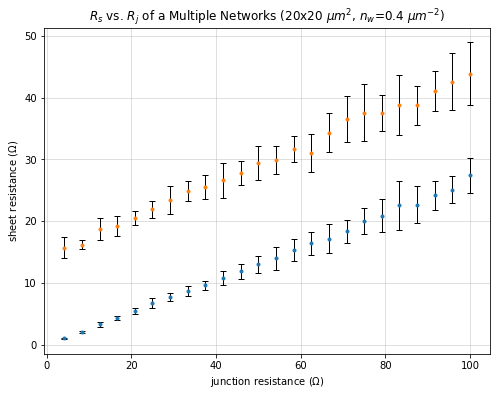

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(junction_array, avg_JDA, fmt=".", yerr=std_JDA, capsize=3, elinewidth=1, ecolor="black")
ax.errorbar(junction_array, avg_MNR, fmt=".", yerr=std_MNR, capsize=3, elinewidth=1, ecolor="black")
ax.set_title(r"$R_s$ vs. $R_j$ of a Multiple Networks (20x20 $\mu m^{2}$, $n_w$=0.4 $\mu m^{-2}$)")
ax.set_xlabel(r"junction resistance ($\Omega$)")
ax.set_ylabel(r"sheet resistance ($\Omega$)")
ax.grid(alpha=0.5)

## R_s versus resistivity Single Network

In [15]:
def resist_func(density, current, resistivity, R_j, NWN_type="JDA"):
    density *= units["l0"]**2
    current /= units["i0"]
    resistivity /= units["rho0"]
    R_j /= units["Ron"]
    size = 20.0 / units["l0"]

    # Create NWN
    NWN = create_NWN(size=size, conductance=1/R_j, density=density, resistivity=resistivity, seed=123)
    left, right = add_electrodes(NWN, "left", "right")
    if NWN_type == "MNR":
        convert_NWN_to_MNR(NWN)

    # Solve network voltages to get sheet resistance
    voltage_list = solve_network(NWN, left, right, current, type="current")
    voltage = voltage_list[-2] - voltage_list[-1]
    return (voltage / current) * units["Ron"]

In [16]:
rho_array = np.linspace(10, 100, 400)
with Parallel(n_jobs=-1, verbose=9) as parallel:
    Rs_list_JDA = parallel([delayed(resist_func)(0.4, 0.1, rho, 11, "JDA") for rho in rho_array])
    Rs_list_MNR = parallel([delayed(resist_func)(0.4, 0.1, rho, 11, "MNR") for rho in rho_array])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 377 out of 400 | elapsed:    5.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    4.0s
[Parallel(n_

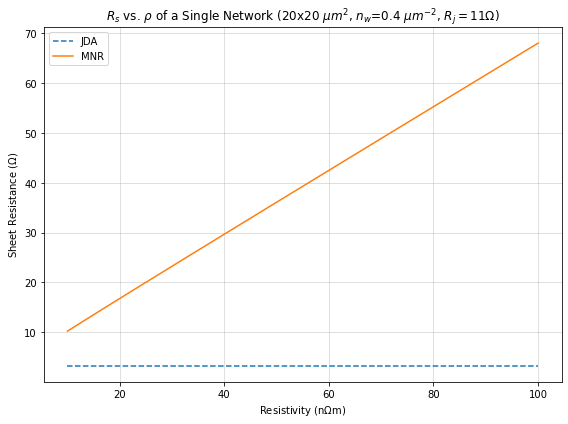

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(rho_array, Rs_list_JDA, "--", label="JDA")
ax.plot(rho_array, Rs_list_MNR, label="MNR")
ax.set_xlabel(r"Resistivity (n$\Omega $m)")
ax.set_ylabel(r"Sheet Resistance ($\Omega$)")
ax.set_title(r"$R_s$ vs. $\rho$ of a Single Network (20x20 $\mu m^{2}$, $n_w$=0.4 $\mu m^{-2}$, $R_j=11\Omega$)")
ax.legend()
ax.grid(alpha=0.5)
fig.tight_layout()
# fig.savefig("figs/Sheet Resistance (Current)/fig2.jpg")

## R_s versus diameter Single Network

In [18]:
def resist_func(density, current, diameter, R_j, NWN_type="JDA"):
    density *= units["l0"]**2
    current /= units["i0"]
    diameter /= units["D0"]
    R_j /= units["Ron"]
    size = 20.0 / units["l0"]

    # Create NWN
    NWN = create_NWN(size=size, conductance=1/R_j, density=density, diameter=diameter, seed=123)
    left, right = add_electrodes(NWN, "left", "right")
    if NWN_type == "MNR":
        convert_NWN_to_MNR(NWN)

    # Solve network voltages to get sheet resistance
    voltage_list = solve_network(NWN, left, right, current, type="current")
    voltage = voltage_list[-2] - voltage_list[-1]
    return (voltage / current) * units["Ron"]

In [19]:
D_array = np.linspace(20, 100, 400)
with Parallel(n_jobs=-1, verbose=9) as parallel:
    Rs_list_JDA = parallel([delayed(resist_func)(0.4, 0.1, D, 11, "JDA") for D in D_array])
    Rs_list_MNR = parallel([delayed(resist_func)(0.4, 0.1, D, 11, "MNR") for D in D_array])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 377 out of 400 | elapsed:    5.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    4.2s
[Parallel(n_

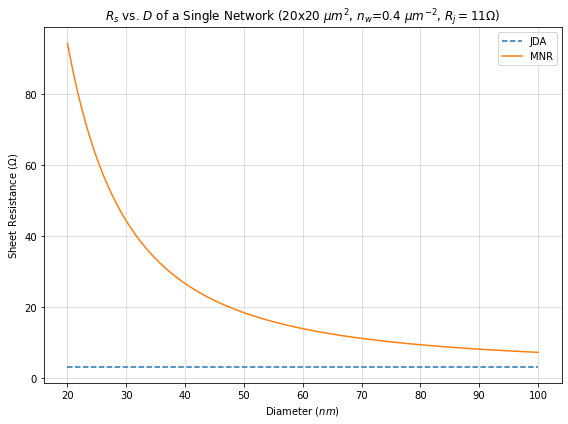

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(D_array, Rs_list_JDA, "--", label="JDA")
ax.plot(D_array, Rs_list_MNR, label="MNR")
ax.set_xlabel(r"Diameter ($nm$)")
ax.set_ylabel(r"Sheet Resistance ($\Omega$)")
ax.set_title(r"$R_s$ vs. $D$ of a Single Network (20x20 $\mu m^{2}$, $n_w$=0.4 $\mu m^{-2}$, $R_j=11\Omega$)")
ax.legend()
ax.grid(alpha=0.5)
fig.tight_layout()
# fig.savefig("figs/Sheet Resistance (Current)/fig3.jpg")

## R_s versus Size (MNR)

In [22]:
def resist_func(current, size, R_j, NWN_type="JDA"):
    current /= units["i0"]
    R_j /= units["Ron"]
    size /= units["l0"]

    # Create NWN
    NWN = create_NWN(size=size, conductance=1/R_j)
    left, right = add_electrodes(NWN, "left", "right")
    if NWN_type == "MNR":
        convert_NWN_to_MNR(NWN)

    # Solve network voltages to get sheet resistance
    voltage_list = solve_network(NWN, left, right, current, type="current")
    voltage = voltage_list[-2] - voltage_list[-1]
    return (voltage / current) * units["Ron"]

In [23]:
repeat_num = 5
size_array = np.linspace(10, 60, 60)

with Parallel(n_jobs=-1, verbose=9) as parallel:
    Rs_list = parallel([delayed(resist_func)(0.1, size, 11, "MNR") for size in size_array.repeat(repeat_num)])

Rs_list = np.array(Rs_list).reshape((-1, repeat_num))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 222 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   36.1s finished


In [24]:
avg = np.mean(Rs_list, axis=1)
std = np.std(Rs_list, axis=1)

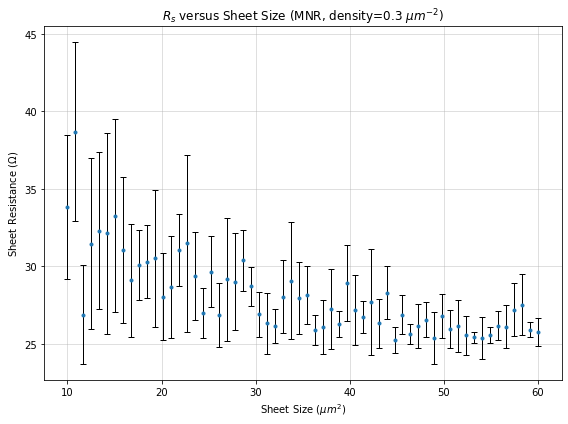

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(size_array, avg, fmt=".", yerr=std, capsize=3, elinewidth=1, ecolor="black")
ax.set_xlabel(r"Sheet Size ($\mu m^2$)")
ax.set_ylabel(r"Sheet Resistance ($\Omega$)")
ax.set_title(r"$R_s$ versus Sheet Size (MNR, density=0.3 $\mu m^{-2}$)")
ax.grid(alpha=0.5)
fig.tight_layout()

# fig.savefig("figs/Sheet Resistance (Current)/fig7.jpg")

## R_s versus Length (MNR)

In [27]:
def resist_func(current, length, width, R_j, NWN_type="JDA"):
    current /= units["i0"]
    R_j /= units["Ron"]
    length /= units["l0"]
    width /= units["l0"]

    # Create NWN
    NWN = create_NWN(size=(length, width), conductance=1/R_j)
    left, right = add_electrodes(NWN, "left", "right")
    if NWN_type == "MNR":
        convert_NWN_to_MNR(NWN)

    # Solve network voltages to get sheet resistance
    voltage_list = solve_network(NWN, left, right, current, type="current")
    voltage = voltage_list[-2] - voltage_list[-1]
    return (voltage / current) * units["Ron"]

In [28]:
repeat_num = 5
length_array = np.linspace(10, 60, 60)
width = 20.0

with Parallel(n_jobs=-1, verbose=9) as parallel:
    Rs_list = parallel([delayed(resist_func)(0.1, length, width, 11, "MNR") for length in length_array.repeat(repeat_num)])

Rs_list = np.array(Rs_list).reshape((-1, repeat_num))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.7s finished


In [29]:
avg = np.mean(Rs_list, axis=1)
std = np.std(Rs_list, axis=1)

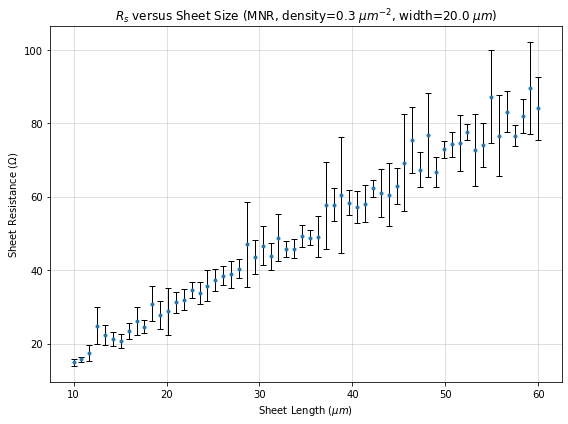

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(length_array, avg, fmt=".", yerr=std, capsize=3, elinewidth=1, ecolor="black")
ax.set_xlabel(r"Sheet Length ($\mu m$)")
ax.set_ylabel(r"Sheet Resistance ($\Omega$)")
ax.set_title(r"$R_s$ versus Sheet Size (MNR, density=0.3 $\mu m^{-2}$, width=20.0 $\mu m$)")
ax.grid(alpha=0.5)
fig.tight_layout()

# fig.savefig("figs/Sheet Resistance (Current)/fig6.jpg")

## R_s versus wire density Single Network (JDA)

In [31]:
def resist_func(density, current, R_j):
    size = 20 / units["l0"]
    density *= units["l0"]**2
    current /= units["i0"]
    R_j /= units["Ron"]

    # Create NWN
    NWN = create_NWN(size=size, conductance=1/R_j, density=density)
    left, right = add_electrodes(NWN, "left", "right")

    # Solve network voltages to get sheet resistance
    voltage_list = solve_network(NWN, left, right, current, type="current")
    voltage = voltage_list[-2] - voltage_list[-1]
    return (voltage / current) * units["Ron"]

In [32]:
density_array = np.logspace(-0.6, 0.4, 400)
with Parallel(n_jobs=-1, verbose=9) as parallel:
    Rs_list = parallel([delayed(resist_func)(density, 0.1, 11) for density in density_array])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 246 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 326 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   51.3s finished


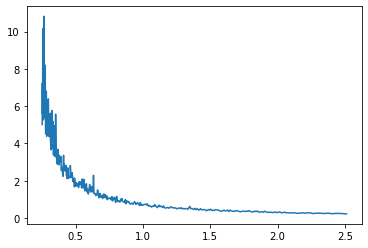

In [33]:
plt.plot(density_array, Rs_list)

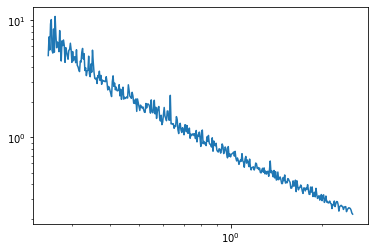

In [34]:
plt.loglog(density_array, Rs_list)

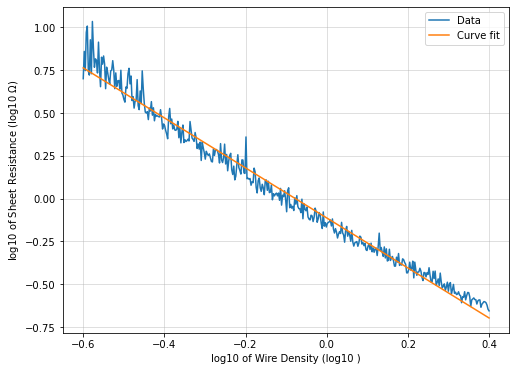

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))
slope, intercept, rvalue, *_ = linregress(np.log10(density_array), np.log10(Rs_list))
ax.plot(np.log10(density_array), np.log10(Rs_list), label="Data")
ax.plot(np.log10(density_array), slope*np.log10(density_array) + intercept, label="Curve fit")
ax.set_xlabel(r"log10 of Wire Density (log10 )")
ax.set_ylabel(r"log10 of Sheet Resistance (log10 $\Omega$)")
ax.legend()
ax.grid(alpha=0.5)

In [36]:
print(f"log-log Plot:\nSlope: {slope:.5f}\nIntercept: {intercept:.5f}\nR^2: {rvalue**2:.5f}")

log-log Plot:
Slope: -1.45993
Intercept: -0.11244
R^2: 0.98121


## R_s versus wire density Ensemble (JDA)

In [37]:
def resist_func(density, current, R_j):
    size = 20 / units["l0"]
    density *= units["l0"]**2
    current /= units["i0"]
    R_j /= units["Ron"]

    # Create NWN
    NWN = create_NWN(size=size, conductance=1/R_j, density=density)
    left, right = add_electrodes(NWN, "left", "right")

    # Solve network voltages to get sheet resistance
    voltage_list = solve_network(NWN, left, right, current, type="current")
    voltage = voltage_list[-2] - voltage_list[-1]
    return (voltage / current) * units["Ron"]

In [38]:
repeat_num = 40
density_array = np.linspace(0.25, 0.6, 15)

with Parallel(n_jobs=-1, verbose=9) as parallel:
    Rs_list = parallel([delayed(resist_func)(density, 30, 11) for density in density_array.repeat(repeat_num)])

Rs_list = np.array(Rs_list).reshape((-1, repeat_num))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   11.0s finished


In [39]:
avg = np.mean(Rs_list, axis=1)
std = np.std(Rs_list, axis=1)

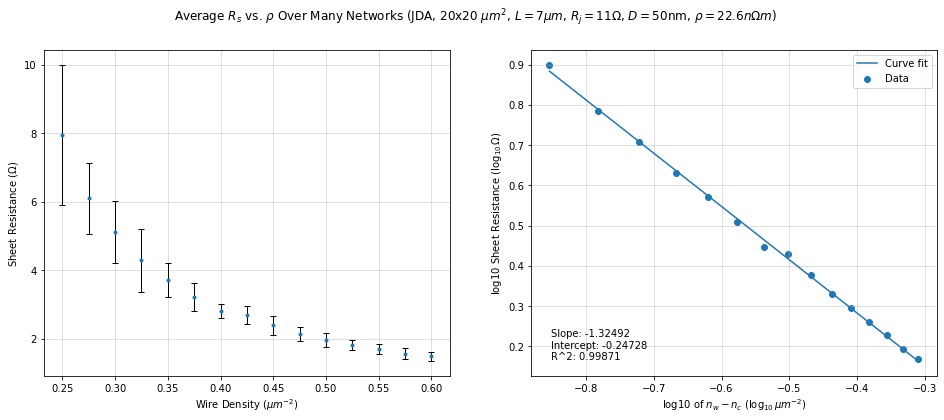

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(r"Average $R_s$ vs. $\rho$ Over Many Networks (JDA, 20x20 $\mu m^2$, $L=7\mu m$, $R_j=11\Omega$, $D=50$nm, $\rho=22.6n\Omega m$)")

ax1.errorbar(density_array, avg, fmt=".", yerr=std, capsize=3, elinewidth=1, ecolor="black")
ax1.set_xlabel(r"Wire Density ($\mu m^{-2}$)")
ax1.set_ylabel(r"Sheet Resistance ($\Omega$)")
ax1.grid(alpha=0.5)

crit = 0.11
log_crit_array = np.log10(density_array - crit)
slope, intercept, rvalue, *_ = linregress(log_crit_array, np.log10(avg))

ax2.scatter(log_crit_array, np.log10(avg), label="Data")
ax2.plot(log_crit_array, slope*log_crit_array + intercept, label="Curve fit")
ax2.text(0.05, 0.05, f"Slope: {slope:.5f}\nIntercept: {intercept:.5f}\nR^2: {rvalue**2:.5f}", transform=ax2.transAxes)
ax2.set_xlabel(r"log10 of $n_w - n_c$ ($\log_{10}\,\mu m^{-2}$)")
ax2.set_ylabel(r"log10 Sheet Resistance ($\log_{10}\,\Omega$)")
ax2.legend()
ax2.grid(alpha=0.5)

# fig.savefig("figs/Sheet Resistance (Current)/fig4.jpg")

## R_s versus wire density Ensemble (MNR)

In [41]:
def resist_func(density, current, R_j=50):
    size = 20 / units["l0"]
    density *= units["l0"]**2
    current /= units["i0"]
    R_j /= units["Ron"]

    # Create NWN
    NWN = create_NWN(size=size, conductance=1/R_j, density=density)
    left, right = add_electrodes(NWN, "left", "right")
    convert_NWN_to_MNR(NWN)

    # Solve network voltages to get sheet resistance
    voltage_list = solve_network(NWN, left, right, current, type="current")
    voltage = voltage_list[-2] - voltage_list[-1]
    return (voltage / current) * units["Ron"]

In [42]:
repeat_num = 30
density_array = np.linspace(0.25, 0.6, 20)

with Parallel(n_jobs=-1, verbose=9) as parallel:
    Rs_list = parallel([delayed(resist_func)(density, 30, 11) for density in density_array.repeat(repeat_num)])

Rs_list = np.array(Rs_list).reshape((-1, repeat_num))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 506 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   24.0s finished


In [43]:
avg = np.mean(Rs_list, axis=1)
std = np.std(Rs_list, axis=1)

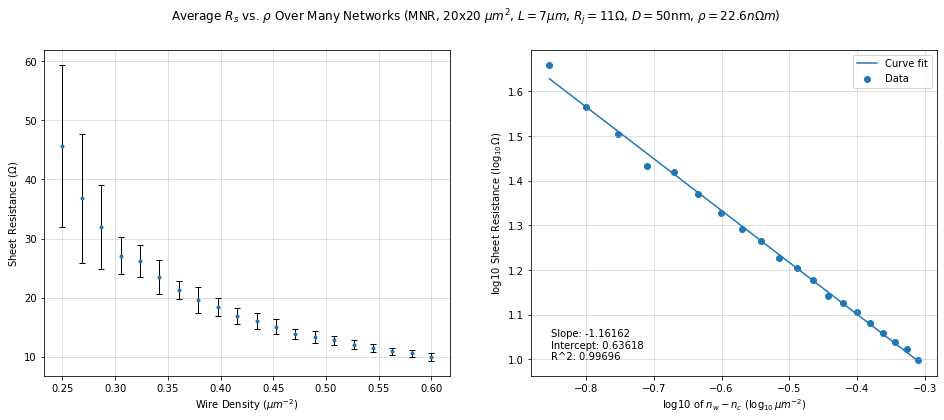

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(r"Average $R_s$ vs. $\rho$ Over Many Networks (MNR, 20x20 $\mu m^2$, $L=7\mu m$, $R_j=11\Omega$, $D=50$nm, $\rho=22.6n\Omega m$)")

ax1.errorbar(density_array, avg, fmt=".", yerr=std, capsize=3, elinewidth=1, ecolor="black")
ax1.set_xlabel(r"Wire Density ($\mu m^{-2}$)")
ax1.set_ylabel(r"Sheet Resistance ($\Omega$)")
ax1.grid(alpha=0.5)

crit = 0.11
slope, intercept, rvalue, *_ = linregress(np.log10(density_array - crit), np.log10(avg))

ax2.scatter(np.log10(density_array - crit), np.log10(avg), label="Data")
ax2.plot(np.log10(density_array - crit), slope*np.log10(density_array - crit) + intercept, label="Curve fit")
ax2.text(0.05, 0.05, f"Slope: {slope:.5f}\nIntercept: {intercept:.5f}\nR^2: {rvalue**2:.5f}", transform=ax2.transAxes)
ax2.set_xlabel(r"log10 of $n_w - n_c$ ($\log_{10}\,\mu m^{-2}$)")
ax2.set_ylabel(r"log10 Sheet Resistance ($\log_{10}\,\Omega$)")
ax2.grid(alpha=0.5)
ax2.legend()

# fig.savefig("figs/Sheet Resistance (Current)/fig5.jpg")

## Theoretical Slopes

In [45]:
def beta(R_j, R_in):
    beta0 = 1.314
    C = 0.108
    zeta = np.log10(R_j / R_in)
    return beta0 + C * erf(zeta)

In [46]:
# R_j = 11 ohms, R_in = 0 ohms
beta(11, 0.0000001)

1.4220000000000002

In [47]:
# R_j = 11 ohms, R_in = 350 ohms
beta(11, 80)

1.2300825885946767